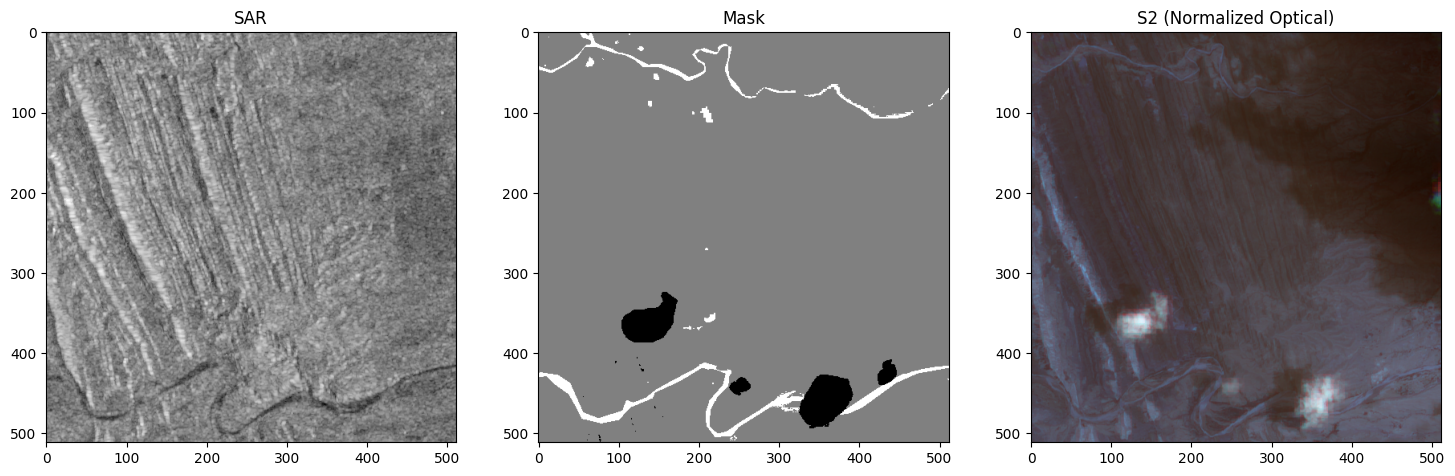

Unique values in mask: [-1  0  1]


In [9]:
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Directories
sar_dir = r"C:\surfacewatermapping\Sen1Floods11\S1Hand"
mask_dir = r"C:\surfacewatermapping\Sen1Floods11\LabelHand"
optical_dir = r"C:\surfacewatermapping\Sen1Floods11\S2Hand"

# List SAR files
sar_files = os.listdir(sar_dir)

# Pick a random SAR file
random_sar = random.choice(sar_files)

# Corresponding mask
mask_name = random_sar.replace("_S1Hand", "_LabelHand")
mask_path = os.path.join(mask_dir, mask_name)

# Corresponding optical (Sentinel-2)
s2_name = random_sar.replace("_S1Hand", "_S2Hand")
s2_path = os.path.join(optical_dir, s2_name)

# Check existence
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask file not found: {mask_path}")
if not os.path.exists(s2_path):
    print(f"S2 image not found for {random_sar}, plotting only SAR and mask")
    s2_path = None

# Read SAR
with rasterio.open(os.path.join(sar_dir, random_sar)) as src:
    sar_image = src.read(1)

# Read Mask
with rasterio.open(mask_path) as src:
    mask_image = src.read(1)

# Read S2 if exists
if s2_path:
    with rasterio.open(s2_path) as src:
        # Assuming bands 1,2,3 are RGB
        s2_image = np.dstack([src.read(1), src.read(2), src.read(3)])
        
    # Normalize S2 to 0-1
    s2_image = s2_image.astype(np.float32)
    s2_image -= s2_image.min()
    s2_image /= s2_image.max()

# Plot
if s2_path:
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    ax[0].imshow(sar_image, cmap='gray')
    ax[0].set_title("SAR")
    ax[1].imshow(mask_image, cmap='gray')
    ax[1].set_title("Mask")
    ax[2].imshow(s2_image)
    ax[2].set_title("S2 (Normalized Optical)")
else:
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].imshow(sar_image, cmap='gray')
    ax[0].set_title("SAR")
    ax[1].imshow(mask_image, cmap='gray')
    ax[1].set_title("Mask")

plt.show()

# Unique values in mask
print("Unique values in mask:", np.unique(mask_image))


In [ ]:
import os
import rasterio
import numpy as np

# --------------------------
# Paths
# --------------------------
sar_dir = r"C:\surfacewatermapping\Sen1Floods11\S1Hand"
mask_dir = r"C:\surfacewatermapping\Sen1Floods11\LabelHand"
output_dir = os.path.join(os.getcwd(), "numpy_patches")
os.makedirs(output_dir, exist_ok=True)

# --------------------------
# Parameters
# --------------------------
patch_size = 128
stride = 128  # reduce to 64 for overlapping patches

all_sar_patches = []
all_mask_patches = []

# --------------------------
# List SAR files
# --------------------------
sar_files = [f for f in os.listdir(sar_dir) if f.endswith(".tif")]

# --------------------------
# Process each file
# --------------------------
for sar_file in sar_files:
    sar_path = os.path.join(sar_dir, sar_file)
    mask_file = sar_file.replace("_S1Hand", "_LabelHand")
    mask_path = os.path.join(mask_dir, mask_file)

    if not os.path.exists(mask_path):
        continue  # skip if corresponding mask doesn't exist

    # --- Load SAR ---
    with rasterio.open(sar_path) as src:
        sar_image = src.read(1).astype(np.float32)

    # Fill NaNs and Infs
    sar_image = np.nan_to_num(sar_image, nan=0.0, posinf=0.0, neginf=0.0)

    # Clip realistic SAR range and normalize
    sar_image = np.clip(sar_image, -25, 0)  # typical dB range for water detection
    sar_norm = (sar_image + 25) / 25        # map -25–0 dB to 0–1

    # --- Load Mask ---
    with rasterio.open(mask_path) as src:
        mask_image = src.read(1).astype(np.float32)

    # Convert mask to 0/1
    mask_image = np.where(mask_image > 0, 1.0, 0.0)

    # --- Patch extraction ---
    h, w = sar_norm.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            sar_patch = sar_norm[i:i+patch_size, j:j+patch_size]
            mask_patch = mask_image[i:i+patch_size, j:j+patch_size]
            all_sar_patches.append(sar_patch)
            all_mask_patches.append(mask_patch)

# --------------------------
# Convert to numpy arrays
# --------------------------
all_sar_patches = np.stack(all_sar_patches).astype(np.float32)
all_mask_patches = np.stack(all_mask_patches).astype(np.float32)

# --------------------------
# Save patches
# --------------------------
np.save(os.path.join(output_dir, "sar_patches.npy"), all_sar_patches)
np.save(os.path.join(output_dir, "mask_patches_sar.npy"), all_mask_patches)

# --------------------------
# Final dataset statistics
# --------------------------
print("\n=== Final Dataset Stats ===")
print("SAR patches shape:", all_sar_patches.shape)
print("Mask patches shape:", all_mask_patches.shape)
print("SAR min:", all_sar_patches.min())
print("SAR max:", all_sar_patches.max())
print("SAR mean:", all_sar_patches.mean())
print("SAR median:", np.median(all_sar_patches))
print("SAR std:", all_sar_patches.std())
print("Mask unique values:", np.unique(all_mask_patches))



=== Final Dataset Stats ===
SAR patches shape: (7136, 128, 128)
Mask patches shape: (7136, 128, 128)
SAR min: 0.0
SAR max: 1.0
SAR mean: 0.5919283
SAR median: 0.6109544
SAR std: 0.17227498
Mask unique values: [0. 1.]


: 

In [6]:
all_sar_patches
print("Mask unique values:", np.unique(all_mask_patches))
print("SAR min/max:", all_sar_patches.min(), all_sar_patches.max())


Mask unique values: [0. 1.]
SAR min/max: 0.0 1.0


In [ ]:
import os
import rasterio
import numpy as np

# Path to SAR data
sar_dir = r"C:\surfacewatermapping\Sen1Floods11\S1Hand"

# Get first 3 SAR files
sar_files = [f for f in os.listdir(sar_dir) if f.endswith('.tif')]
sar_files = sorted(sar_files)[:3]

for f in sar_files:
    path = os.path.join(sar_dir, f)
    with rasterio.open(path) as src:
        img = src.read(1)  # first band
        
        # Stats
        min_val = np.nanmin(img)
        max_val = np.nanmax(img)
        mean_val = np.nanmean(img)
        median_val = np.nanmedian(img)
        std_val = np.nanstd(img)
        nan_count = np.isnan(img).sum()
        zero_count = np.sum(img == 0)
        
        print(f"\nFile: {f}")
        print(f" Shape: {img.shape}")
        print(f" Min: {min_val}, Max: {max_val}")
        print(f" Mean: {mean_val}, Median: {median_val}, Std: {std_val}")
        print(f" NaN count: {nan_count}, Zero count: {zero_count}")



File: Bolivia_103757_S1Hand.tif
 Shape: (512, 512)
 Min: -40.821441650390625, Max: -0.6905989646911621
 Mean: -13.010356903076172, Median: -11.734638214111328, Std: 5.581782817840576
 NaN count: 160521, Zero count: 0

File: Bolivia_129334_S1Hand.tif
 Shape: (512, 512)
 Min: -36.82529830932617, Max: 0.4744816720485687
 Mean: -14.148340225219727, Median: -14.907347679138184, Std: 4.7108378410339355
 NaN count: 749, Zero count: 0

File: Bolivia_195474_S1Hand.tif
 Shape: (512, 512)
 Min: -23.107797622680664, Max: 7.00493049621582
 Mean: -7.8903117179870605, Median: -7.727375030517578, Std: 2.444056749343872
 NaN count: 0, Zero count: 0


=== Bolivia_103757_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -40.82144
Max: 0.0
Mean: -5.0436077
Std: 7.2290535
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
----------------------------------------
=== Bolivia_129334_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -36.8253
Max: 0.47448167
Mean: -14.107916
Std: 4.7643366
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
----------------------------------------
=== Bolivia_195474_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -23.107798
Max: 7.0049305
Mean: -7.8903117
Std: 2.4440567
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
----------------------------------------


In [19]:
import os
import rasterio
import numpy as np

# Paths
sar_dir = r"C:\surfacewatermapping\Sen1Floods11\S1Hand"
sar_files = [f for f in os.listdir(sar_dir) if f.endswith(".tif")]

for sar_file in sar_files[:3]:  # test only first 3 images
    sar_path = os.path.join(sar_dir, sar_file)
    
    with rasterio.open(sar_path) as src:
        sar_image = src.read(1).astype(np.float32)
        nodata_val = src.nodata
        missing_pixels = 0
        if nodata_val is not None:
            missing_pixels = np.sum(sar_image == nodata_val)
            sar_image[sar_image == nodata_val] = 0.0
        
        # Replace any NaNs/Infs just in case
        sar_image = np.nan_to_num(sar_image, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"=== {sar_file} RAW ===")
    print("Shape:", sar_image.shape)
    print("Dtype:", sar_image.dtype)
    print("Min:", sar_image.min())
    print("Max:", sar_image.max())
    print("Mean:", sar_image.mean())
    print("Std:", sar_image.std())
    print("NaNs:", np.isnan(sar_image).sum())
    print("Infs:", np.isinf(sar_image).sum())
    print("Missing pixels (nodata):", missing_pixels)
    
    # Clip + normalize for model input
    sar_clip = np.clip(sar_image, -25, 0)         # clip for sanity
    sar_norm = (sar_clip + 25) / 25               # map -25–0 dB to 0–1
    
    print(f"=== {sar_file} CLIPPED+NORMALIZED ===")
    print("Min:", sar_norm.min())
    print("Max:", sar_norm.max())
    print("Mean:", sar_norm.mean())
    print("Std:", sar_norm.std())
    print("NaNs:", np.isnan(sar_norm).sum())
    print("Infs:", np.isinf(sar_norm).sum())
    print("----------------------------------------")


=== Bolivia_103757_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -40.82144
Max: 0.0
Mean: -5.0436077
Std: 7.2290535
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_103757_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.0
Max: 1.0
Mean: 0.79861355
Std: 0.288084
NaNs: 0
Infs: 0
----------------------------------------
=== Bolivia_129334_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -36.8253
Max: 0.47448167
Mean: -14.107916
Std: 4.7643366
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_129334_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.0
Max: 1.0
Mean: 0.43596506
Std: 0.189833
NaNs: 0
Infs: 0
----------------------------------------
=== Bolivia_195474_S1Hand.tif RAW ===
Shape: (512, 512)
Dtype: float32
Min: -23.107798
Max: 7.0049305
Mean: -7.8903117
Std: 2.4440567
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_195474_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.075688094
Max: 1.0
Mean: 0.68437964
Std: 0.09772947
NaNs: 0
Infs: 0
-------------------------------

In [21]:
import os
import rasterio
import numpy as np

# Paths
sar_dir = r"C:\surfacewatermapping\Sen1Floods11\S1Hand"
sar_files = [f for f in os.listdir(sar_dir) if f.endswith(".tif")]

for sar_file in sar_files[:3]:  # test only first 3 images
    sar_path = os.path.join(sar_dir, sar_file)
    
    with rasterio.open(sar_path) as src:
        sar_image = src.read(1).astype(np.float32)
        nodata_val = src.nodata
        
        # --- Check missing pixels BEFORE cleaning ---
        missing_pixels = 0
        if nodata_val is not None:
            missing_pixels = np.sum(sar_image == nodata_val)
        nan_pixels = np.isnan(sar_image).sum()
        inf_pixels = np.isinf(sar_image).sum()
        
        print(f"=== {sar_file} RAW (before cleaning) ===")
        print("Shape:", sar_image.shape)
        print("Dtype:", sar_image.dtype)
        print("Min:", np.nanmin(sar_image))
        print("Max:", np.nanmax(sar_image))
        print("Mean:", np.nanmean(sar_image))
        print("Std:", np.nanstd(sar_image))
        print("NaNs:", nan_pixels)
        print("Infs:", inf_pixels)
        print("Missing pixels (nodata):", missing_pixels)
        
        # --- Now clean for model ---
        if nodata_val is not None:
            sar_image[sar_image == nodata_val] = 0.0
        sar_image = np.nan_to_num(sar_image, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Clip + normalize
        sar_clip = np.clip(sar_image, -25, 0)
        sar_norm = (sar_clip + 25) / 25
        
        print(f"=== {sar_file} CLIPPED+NORMALIZED ===")
        print("Min:", sar_norm.min())
        print("Max:", sar_norm.max())
        print("Mean:", sar_norm.mean())
        print("Std:", sar_norm.std())
        print("NaNs:", np.isnan(sar_norm).sum())
        print("Infs:", np.isinf(sar_norm).sum())
        print("----------------------------------------")


=== Bolivia_103757_S1Hand.tif RAW (before cleaning) ===
Shape: (512, 512)
Dtype: float32
Min: -40.82144
Max: -0.69059896
Mean: -13.010357
Std: 5.581783
NaNs: 160521
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_103757_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.0
Max: 1.0
Mean: 0.79861355
Std: 0.288084
NaNs: 0
Infs: 0
----------------------------------------
=== Bolivia_129334_S1Hand.tif RAW (before cleaning) ===
Shape: (512, 512)
Dtype: float32
Min: -36.8253
Max: 0.47448167
Mean: -14.14834
Std: 4.710838
NaNs: 749
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_129334_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.0
Max: 1.0
Mean: 0.43596506
Std: 0.189833
NaNs: 0
Infs: 0
----------------------------------------
=== Bolivia_195474_S1Hand.tif RAW (before cleaning) ===
Shape: (512, 512)
Dtype: float32
Min: -23.107798
Max: 7.0049305
Mean: -7.8903117
Std: 2.4440567
NaNs: 0
Infs: 0
Missing pixels (nodata): 0
=== Bolivia_195474_S1Hand.tif CLIPPED+NORMALIZED ===
Min: 0.075688094
Max: 1.0
Mean: 0.684379